# Protein Classificator

## Importing required packages

In [1]:
!pip3.7 install biopython

     |████████████████████████████████| 2.3 MB 40.3 MB/s 


In [2]:
 !pip3.7 install fair-esm

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy

from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

import esm
import torch
from matplotlib.colors import ListedColormap

Command to run to open data files in Google Colab environment.

In [4]:
!unzip data.zip

Archive:  data.zip
   creating: data/FASTA/
  inflating: data/FASTA/filtered_testing_sequences.fasta  
  inflating: data/FASTA/.DS_Store    
  inflating: data/FASTA/filtered_training_sample_sequences.fasta  
  inflating: data/FASTA/testing_sequences.fasta  
  inflating: data/FASTA/training_sequences.fasta  
  inflating: data/FASTA/validation_sequences.fasta  
  inflating: data/FASTA/filtered_validation_sequences.fasta  
  inflating: data/FASTA/filtered_training_sequences.fasta  
   creating: data/NPZ/
  inflating: data/NPZ/training_and_validation_embeddings.npz  
   creating: data/proteomes/
  inflating: data/proteomes/.DS_Store  
  inflating: data/proteomes/UP000008183.fasta  
  inflating: data/proteomes/UP000000798.fasta  
  inflating: data/proteomes/UP000001974_273057.fasta  
  inflating: data/proteomes/UP000077428.fasta  
  inflating: data/proteomes/UP000000625_83333.fasta  
  inflating: data/proteomes/UP000000792.fasta  


## Configuration of temperature labels and input files

In [ ]:
temperature_labels_full = [37, 80]

files = ['data/proteomes/UP000000625_83333.fasta', 'data/proteomes/UP000001974_273057.fasta']

## Splitting the dataset for training, validation and testing

The proportions for splitting were chosen to be 70%, 15% and 15% for training, validation and testing respectively.

In [ ]:
# Initialisation of the dataset container
data = {
    'train': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/training_',
        'CSV_prefix': 'data/CSV/training_',
    },
    'validate': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/validation_',
        'CSV_prefix': 'data/CSV/validation_'
    },
    'test': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/testing_',
        'CSV_prefix': 'data/CSV/testing_'
    }
}

# Removing duplicate sequences in the dataset
seen = set()

for i in range(len(temperature_labels_full)):
    records = [] 
    # Parsing sequences (X dataset) from one dataset 
    for record in SeqIO.parse(files[i], "fasta"):
        if record.seq not in seen:
            seen.add(record.seq)
            records.append(record)

    # Creating Y dataset from temperature labels 
    temperature_labels = [temperature_labels_full[i]] * len(records)

    # Spliting the dataset to 70% (training) and 30% (trying)
    X_train, X_try, Y_train, Y_try = train_test_split(records, temperature_labels, test_size=0.3, shuffle=True, random_state=1)

    # Splitting 30% from the initial set in half for calidation and testing
    X_validate, X_test, Y_validate, Y_test = train_test_split(X_try, Y_try, test_size=0.5, shuffle=True, random_state=1)

    data['train']['X'] = data['train']['X'] + X_train
    data['train']['Y'] = data['train']['Y'] + Y_train
    data['validate']['X'] = data['validate']['X'] + X_validate
    data['validate']['Y'] = data['validate']['Y'] + Y_validate
    data['test']['X'] = data['test']['X'] + X_test
    data['test']['Y'] = data['test']['Y'] + Y_test

# Shuffling the datasets
for element in data.keys():
    data[element]['X'], data[element]['Y'] = shuffle(data[element]['X'], data[element]['Y'], random_state=1)



## Checking the success of parsing

In [ ]:
print(len(seen))
print(len(data['train']['X']))
print(len(data['validate']['X']))
print(len(data['test']['X']))

7288
5101
1093
1094


## Checking the maximum length

In [ ]:
max_length = 0
max_length_seq = None

for element in data.keys():
    for i in range(len(data[element]['X'])):
        if(len(data[element]['X'][i].seq) > max_length):
            max_length = len(data[element]['X'][i].seq)
            max_length_seq = data[element]['X'][i]

print(max_length)
print(max_length_seq)

2358
ID: sp|P76347|YEEJ_ECOLI
Name: sp|P76347|YEEJ_ECOLI
Description: sp|P76347|YEEJ_ECOLI Uncharacterized protein YeeJ OS=Escherichia coli (strain K12) OX=83333 GN=yeeJ PE=3 SV=3
Number of features: 0
Seq('MATKKRSGEEINDRQILCGMGIKLRRLTAGICLITQLAFPMAAAAQGVVNAATQ...KNL')


## Creating files 

`[training|validation|testing]_sequences.fasta`

In [ ]:
# Creating data/FASTA/*_sequences.fasta files

for element in data.keys():
    file_name = data[element]['FASTA_prefix']+'sequences.fasta'
    file_handle = open(file_name, 'w')
    for record in data[element]['X']:
        file_handle.write('>'+record.name.split('|')[1])
        file_handle.write("\n")
        file_handle.write(str(record.seq))
        file_handle.write("\n")
    file_handle.close()

  `[training|validation|testing]_temperature_annotations.csv`

In [ ]:
# Creating data/*_temperature_annotations.csv files

for element in data.keys():
    file_name = data[element]['CSV_prefix']+'temperature_annotations.csv'
    file_handle = open(file_name, 'w')
    file_handle.write('identifier,label'+"\n")
    for i in range(len(data[element]['X'])):
        file_handle.write(data[element]['X'][i].name.split('|')[1]+','+str(data[element]['Y'][i]))
        file_handle.write("\n")
    file_handle.close()

## Filtering sequences from initial FASTA files 

Since the visualisation is not allowed without embedding for each FASTA sequence, it was required to filter all sequences and keep only those that have their embeddings.

In [ ]:
data_filtered = {
    'train': {
        'X': [],
        'Y': [],
        'FASTA_prefix': 'data/FASTA/filtered_training_',
        'CSV_prefix': 'data/CSV/filtered_training_',
        'embedding_list': './data/EMB_ESM1b/training_embeddings_sample.lst',
        'embeddings': '/content/drive/MyDrive/training_embeddings_sample'
    },
    'validate': {
        'X': [],
        'Y': [],
        'FASTA_prefix': 'data/FASTA/filtered_validation_',
        'CSV_prefix': 'data/CSV/filtered_validation_',
        'embedding_list': './data/EMB_ESM1b/validation_embeddings.lst',
        'embeddings': '/content/drive/MyDrive/validation_sequences'
    },
    'test': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/filtered_testing_',
        'CSV_prefix': 'data/CSV/filtered_testing_',
        'embedding_list': './data/EMB_ESM1b/testing_embeddings.lst',
        'embeddings': '/content/drive/MyDrive/testing_sequences'
    }
}

for element in data.keys():
    emb_list_handle = open(data_filtered[element]['embedding_list'], 'r')
    emb_list = emb_list_handle.readlines()
    emb_list_handle.close()
    emb_set = set()
    for j in range(len(emb_list)):
        emb_set.add(emb_list[j].split('.')[0])
    for i in range(len(data[element]['X'])):
        if(data[element]['X'][i].id.split('|')[1] in emb_set):
            data_filtered[element]['X'].append(data[element]['X'][i])
            data_filtered[element]['Y'].append(data[element]['Y'][i])


Testing, whether the filtration was successful.

In [ ]:
print(len(data_filtered['train']['X']))
print(len(data_filtered['validate']['X']))
print(len(data_filtered['test']['X']))

1264
1079
1080


## Creating filtered FASTA files

In [ ]:
# Creating data/FASTA/filtered_*_sequences.fasta files

for element in data_filtered.keys():
    file_name = data_filtered[element]['FASTA_prefix']+'sequences.fasta'
    file_handle = open(file_name, 'w')
    for i in range(len(data_filtered[element]['X'])):
    #for i in range(5):
        #file_handle.write('>'+record.name.split('|')[1])
        file_handle.write('>'+data_filtered[element]['X'][i].name.split('|')[1]+'|'+str(data_filtered[element]['Y'][i]))
        #print('>'+data_filtered[element]['X'][i].name.split('|')[1]+'|'+str(data_filtered[element]['Y'][i]))
        file_handle.write("\n")
        file_handle.write(str(record.seq))
        file_handle.write("\n")
    file_handle.close()

## Fetching data of embeddings 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualisation of embeddings

In [ ]:
!pip3.7 install pymde

     |████████████████████████████████| 134 kB 36.4 MB/s 
     |████████████████████████████████| 1.1 MB 29.9 MB/s 
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=49bdae5954f3ec8e88b424b007ecff1555ef82f8a644d38bb32c76b84610826d
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built pynndescent


In [ ]:
import pymde

EMB_LAYER = 33

### Visualisation of training dataset sample embeddings

In [ ]:
Ys = []
Xs = []

keys = ['train']

for key in keys:
    FASTA_PATH = 'data/FASTA/filtered_training_sample_sequences.fasta'
    EMB_PATH = data_filtered[key]['embeddings']
    for header, _seq in esm.data.read_fasta(FASTA_PATH):
        temperature_label = header.split('|')[-1]
        Ys.append(int(temperature_label))
        file_name = header.split('|')[0][1:]
        fn = f'{EMB_PATH}/{file_name}.pt'
        embs = torch.load(fn)
        Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()

In [ ]:
custom_cmap = ListedColormap(["navy", "pink"])

In [ ]:
pca = PCA(60)
Xs_train_pca = pca.fit_transform(Xs)

NameError: ignored

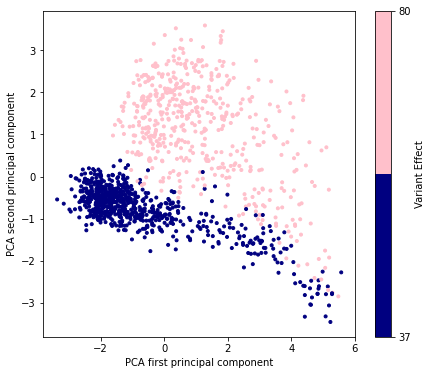

In [ ]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=Ys, marker='.', cmap=custom_cmap)
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect', ticks=numpy.linspace(37, 80, 2))
plt.savefig('training_sample_visualisation_matplotlib.png')

In [ ]:
Xs_torch_train = None

Xs_torch_train = torch.from_numpy(Xs)

embedding_train = pymde.preserve_neighbors(Xs_torch_train).embed(verbose=True)

Nov 24 10:04:02 AM: Fitting a centered embedding into R^2, for a graph with 1264 items and 12115 edges.
Nov 24 10:04:02 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Nov 24 10:04:02 AM: iteration 000 | distortion 0.621243 | residual norm 0.232424 | step length 0.193571 | percent change 0.0894813
Nov 24 10:04:02 AM: iteration 030 | distortion 0.211123 | residual norm 0.002074 | step length 1 | percent change 0.678645
Nov 24 10:04:02 AM: iteration 060 | distortion 0.204533 | residual norm 0.00124083 | step length 1 | percent change 0.428722
Nov 24 10:04:02 AM: iteration 090 | distortion 0.202810 | residual norm 0.000602884 | step length 1 | percent change 0.105649
Nov 24 10:04:03 AM: iteration 120 | distortion 0.202534 | residual norm 0.00035719 | step length 1 | percent change 0.136279
Nov 24 10:04:03 AM: iteration 150 | distortion 0.202260 | residual norm 0.000440381 | step length 1 | percent change 0.102844
Nov 24 10:04:03 AM: iteration 180 | distortion 0.20

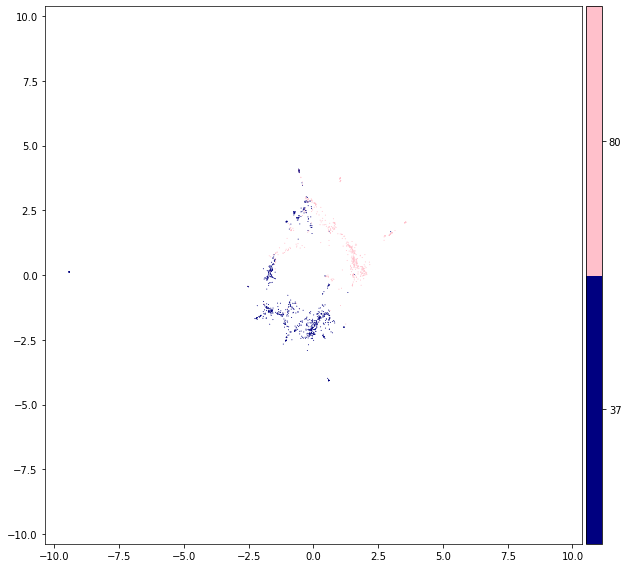

In [ ]:
pymde.plot(embedding_train, color_by=Ys, savepath='training_sample_visualisation_PyMDE.png', color_map=custom_cmap, figsize_inches=(8.8, 8.0))

### Visualisation of validation and testing dataset embeddings

In [ ]:
Ys = []
Xs = []

keys = ['validate', 'test']

for key in keys:
    FASTA_PATH = data_filtered[key]['FASTA_prefix']+'sequences.fasta'
    EMB_PATH = data_filtered[key]['embeddings']
    for header, _seq in esm.data.read_fasta(FASTA_PATH):
        temperature_label = header.split('|')[-1]
        Ys.append(int(temperature_label))
        file_name = header.split('|')[0][1:]
        fn = f'{EMB_PATH}/{file_name}.pt'
        embs = torch.load(fn)
        Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()


Testing the parsing.

In [ ]:
print(len(Ys))
print(Xs.shape)

1264
(1264, 1280)


In [ ]:
pca = PCA(60)
Xs_train_pca = pca.fit_transform(Xs)

In [ ]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=Ys, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect', ticks=numpy.linspace(37, 80, 2))
plt.savefig('validation_and_testing_sequences_visualisation_matplotlib.png')

In [ ]:
Xs_torch_validate = torch.from_numpy(Xs)

embedding = pymde.preserve_neighbors(Xs_torch_validate).embed(verbose=True)

Nov 24 04:38:45 AM: Fitting a centered embedding into R^2, for a graph with 1079 items and 8666 edges.
Nov 24 04:38:45 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Nov 24 04:38:45 AM: iteration 000 | distortion 1.442911 | residual norm 7.53011 | step length 0.0107889 | percent change 0.174885
Nov 24 04:38:45 AM: iteration 030 | distortion 0.230945 | residual norm 0.00364484 | step length 1 | percent change 1.61362
Nov 24 04:38:45 AM: iteration 060 | distortion 0.212735 | residual norm 0.0016108 | step length 1 | percent change 0.519119
Nov 24 04:38:46 AM: iteration 090 | distortion 0.205151 | residual norm 0.00107397 | step length 1 | percent change 0.680107
Nov 24 04:38:46 AM: iteration 120 | distortion 0.201872 | residual norm 0.000999554 | step length 1 | percent change 0.622068
Nov 24 04:38:46 AM: iteration 150 | distortion 0.200445 | residual norm 0.000800306 | step length 1 | percent change 0.538189
Nov 24 04:38:46 AM: iteration 180 | distortion 0.1996

In [ ]:
pymde.plot(embedding, color_by=Ys, savepath='validation_and_testing_sequences_visualisation_PyMDE.png', figsize_inches=(8.8, 8.0))

-------------------------------------------

## Perceptron

Based on: 

https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/

### Preparing data 

In [ ]:
EMB_LAYER = 33

Ys_train = []
Xs_train = []

keys = ['train']

for key in keys:
    FASTA_PATH = 'data/FASTA/filtered_training_sample_sequences.fasta'
    EMB_PATH = data_filtered[key]['embeddings']
    for header, _seq in esm.data.read_fasta(FASTA_PATH):
        temperature_label = header.split('|')[-1]
        Ys_train.append(int(temperature_label))
        file_name = header.split('|')[0][1:]
        fn = f'{EMB_PATH}/{file_name}.pt'
        embs = torch.load(fn)
        Xs_train.append(embs['mean_representations'][EMB_LAYER])

Xs_train = torch.stack(Xs_train, dim=0).numpy()

Xs_torch_train = None

Xs_torch_train = torch.from_numpy(Xs_train)


In [ ]:
embedding_train = pymde.preserve_neighbors(Xs_torch_train).embed(verbose=True)

Dec 04 01:53:31 PM: Fitting a centered embedding into R^2, for a graph with 1264 items and 12112 edges.
Dec 04 01:53:31 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Dec 04 01:53:31 PM: iteration 000 | distortion 0.620555 | residual norm 0.363411 | step length 0.184278 | percent change 0.133193
Dec 04 01:53:32 PM: iteration 030 | distortion 0.209440 | residual norm 0.00197105 | step length 1 | percent change 1.16701
Dec 04 01:53:32 PM: iteration 060 | distortion 0.203690 | residual norm 0.00112998 | step length 1 | percent change 0.380244
Dec 04 01:53:32 PM: iteration 090 | distortion 0.202464 | residual norm 0.000572271 | step length 1 | percent change 0.289055
Dec 04 01:53:32 PM: iteration 120 | distortion 0.202139 | residual norm 0.000258306 | step length 1 | percent change 0.0931606
Dec 04 01:53:32 PM: iteration 150 | distortion 0.202034 | residual norm 0.000382103 | step length 1 | percent change 0.680357
Dec 04 01:53:32 PM: iteration 180 | distortion 0.

In [ ]:
# Preparing labels' data for training.
Ys_array_train = numpy.asarray(Ys_train)
Ys_array_train = Ys_array_train.astype('float32')
Ys_torch_train = torch.from_numpy(Ys_array_train)

In [ ]:
print(Xs_torch_train.shape)
print(Ys_torch_train.shape)
print(Ys_torch_train.size())

torch.Size([1264, 1280])
torch.Size([1264])
torch.Size([1264])


In [ ]:
Ys_validate = []
Xs_validate = []

keys = ['validate']

for key in keys:
    FASTA_PATH = data_filtered[key]['FASTA_prefix']+'sequences.fasta'
    EMB_PATH = data_filtered[key]['embeddings']
    for header, _seq in esm.data.read_fasta(FASTA_PATH):
        temperature_label = header.split('|')[-1]
        Ys_validate.append(int(temperature_label))
        file_name = header.split('|')[0][1:]
        fn = f'{EMB_PATH}/{file_name}.pt'
        embs = torch.load(fn)
        Xs_validate.append(embs['mean_representations'][EMB_LAYER])

Xs_validate = torch.stack(Xs_validate, dim=0).numpy()

Xs_torch_validate = torch.from_numpy(Xs_validate)

embedding = pymde.preserve_neighbors(Xs_torch_validate).embed(verbose=True)

Dec 05 06:02:19 AM: Fitting a centered embedding into R^2, for a graph with 1079 items and 8654 edges.
Dec 05 06:02:19 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Dec 05 06:02:19 AM: iteration 000 | distortion 1.450393 | residual norm 21.1339 | step length 0.00873675 | percent change 0.397469
Dec 05 06:02:19 AM: iteration 030 | distortion 0.236518 | residual norm 0.00389965 | step length 1 | percent change 2.51759
Dec 05 06:02:19 AM: iteration 060 | distortion 0.210114 | residual norm 0.00258052 | step length 1 | percent change 0.939943
Dec 05 06:02:19 AM: iteration 090 | distortion 0.201626 | residual norm 0.00109585 | step length 1 | percent change 0.669384
Dec 05 06:02:20 AM: iteration 120 | distortion 0.198683 | residual norm 0.00102314 | step length 1 | percent change 0.543423
Dec 05 06:02:20 AM: iteration 150 | distortion 0.197381 | residual norm 0.000749343 | step length 1 | percent change 0.0892129
Dec 05 06:02:20 AM: iteration 180 | distortion 0.19

In [ ]:
# Preparing labels' data for validation.
Ys_array_validate = numpy.asarray(Ys_validate)
Ys_torch_validate = torch.from_numpy(Ys_array_validate)

### Saving training and validation data to NPZ files

In [ ]:
names = ['x_train', 'y_train', 'x_validate', 'y_validate']
data = [Xs_torch_train, Ys_torch_train, Xs_torch_validate, Ys_torch_validate]
numpy.savez('training_and_validation_embeddings.npz', **{name:value for name,value in zip(names,data)})

### Defining functions

The weights and biases need to be initialized for the model. There are as many weights as dimensions in the input (embedding).

We will initialize weights with random numbers from -0.5 to 0.5.

In [ ]:
import random

def get_initialized_weights(X):
    number_of_weights = len(X[0])
    weights = []
    for i in range(number_of_weights):
        weights.append(random.uniform(-0.5, 0.5))
    return weights

def activation(X, weights, bias):
    activation = bias
    for i in range(len(X)):
        activation += weights[i] * X[i]
    return activation

def predict(X, weights, bias):
    activ = activation(X, weights, bias)
    return 80 if(activ > 0) else 37

# Function to train network weights using a stochastic gradient descent.
def train_weights(Xs, Ys, weights, bias, learning_rate, number_of_epochs):
    for i in range(number_of_epochs):
        sum_error = 0.0
        for j in range(len(Xs)):
            prediction = predict(Xs[i], weights, bias)
            error = Ys[i] - prediction
            sum_error += error**2
            bias = bias + learning_rate * error
            for k in range(len(weights)):
                weights[j] = weights[j] + learning_rate * error * Xs[j][k]
        print('>epoch=%d, learning_rate=%.3f, error=%.3f' % (i, learning_rate, sum_error))
    return [weights, bias]

def get_accuracy(predictions, Ys):
    match_sum = 0
    for i in range(len(predictions)):
        if(predictions[i] == Ys[i].item()):
            match_sum += 1
    return (match_sum/len(predictions))*100

def get_predictions(Xs, weights, bias):
    predictions = []
    for i in range(len(Xs)):
        predictions.append(predict(Xs[i], weights, bias))
    return predictions

### Checking prediction accuracy of an untrained perceptron.

In [ ]:
random.seed(1)

weights = get_initialized_weights(Xs_torch_train)
bias = -0.1

match_sum = 0
for i in range(len(Xs_torch_train)):
    if(predict(Xs_torch_train[i], weights, bias) == Ys_torch_train[i].item()):
        match_sum += 1

# Accuracy
print('Accuracy with randomly initialized weights:', match_sum/len(Xs_torch_train))

Accuracy with randomly initialized weights: 0.5941455696202531


### Training 

In [ ]:
learning_rate = 0.1
number_of_epochs = 5
[weights, bias] = train_weights(Xs_torch_train, Ys_torch_train, weights, bias, learning_rate, number_of_epochs)

>epoch=0, learning_rate=0.100, error=59168.000
>epoch=1, learning_rate=0.100, error=0.000
>epoch=2, learning_rate=0.100, error=281048.000
>epoch=3, learning_rate=0.100, error=0.000
>epoch=4, learning_rate=0.100, error=0.000


### Validating the trained model

In [ ]:
predictions = get_predictions(Xs_torch_validate, weights, bias)
print(get_accuracy(predictions, Ys_torch_validate))

59.49953660797034


# Perceptron II

Loading data from NPZ file.

In [43]:
with numpy.load('data/NPZ/training_and_validation_embeddings.npz') as data_loaded:
  train_examples = data_loaded['x_train']
  train_labels = data_loaded['y_train']
  validate_examples = data_loaded['x_validate']
  validate_labels = data_loaded['y_validate']

In [44]:
x_train_torch = torch.from_numpy(train_examples)
y_train_torch = torch.from_numpy(train_labels)
x_validate_torch = torch.from_numpy(validate_examples)
y_validate_torch = torch.from_numpy(validate_labels)

In [46]:
NUM_OF_BATCHES = 16

residual = len(x_validate_torch) % NUM_OF_BATCHES

if(residual != 0):
    x_validate_torch = x_validate_torch[0:len(x_validate_torch)-residual]
    y_validate_torch = y_validate_torch[0:len(y_validate_torch)-residual]

print(len(x_validate_torch))
print(len(y_validate_torch))

1072
1072


Adjusting data for a binary classification

In [47]:
for i in range(len(y_train_torch)):
    if(y_train_torch[i] == 80):
        y_train_torch[i] = 1
    elif(y_train_torch[i] == 37):
        y_train_torch[i] = 0

for i in range(len(y_validate_torch)):
    if(y_validate_torch[i] == 80):
        y_validate_torch[i] = 1
    elif(y_validate_torch[i] == 37):
        y_validate_torch[i] = 0

Preparing Torch Dataset and DataLoader

In [48]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import seaborn as sns
from torch.utils.data import TensorDataset
from torch import nn
  
train_dataset = TensorDataset(x_train_torch, y_train_torch)  
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

validate_dataset = TensorDataset(x_validate_torch, y_validate_torch)  
validateloader = DataLoader(validate_dataset, batch_size=16, shuffle=True)

In [49]:
print(len(trainloader.dataset))
print(len(validateloader.dataset))

1264
1072


Initializing the model

In [71]:
class SLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1280, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [74]:
# Set fixed random number seed
torch.manual_seed(42)

# Initialize the SLP
slp = SLP()

# Define the loss function (with activation function) and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(slp.parameters(), lr=1e-4)

def train_epoch(slp, trainloader, loss_function, optimizer):
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs, targets = data
        targets = targets.reshape(16, 1)
        targets = targets.to(torch.float32)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = slp(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 16 == 15:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 16))
            current_loss = 0.0

def validation_epoch(slp, validateloader, loss_function):
    current_loss = 0.0 

     # Iterate over the DataLoader for training data
    for i, data in enumerate(validateloader, 0):
        # Get inputs
        inputs, targets = data
        targets = targets.reshape(16, 1)
        targets = targets.to(torch.float32)
        
        # Compute loss
        outputs = slp(inputs)
        loss = loss_function(outputs, targets)
        
        # Print statistics
        current_loss += loss.item()
        if i % 16 == 15:
            print('Validation loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 16))
            current_loss = 0.0
        

for epoch in range(0, 79):
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    train_epoch(slp, trainloader, loss_function, optimizer)
    validation_epoch(slp, trainloader, loss_function)
  
print('Training and validation process has finished.')

Starting epoch 1
Loss after mini-batch    16: 0.661
Loss after mini-batch    32: 0.639
Loss after mini-batch    48: 0.621
Loss after mini-batch    64: 0.596
Validation loss after mini-batch    16: 0.580
Validation loss after mini-batch    32: 0.577
Validation loss after mini-batch    48: 0.565
Validation loss after mini-batch    64: 0.581
Starting epoch 2
Loss after mini-batch    16: 0.576
Loss after mini-batch    32: 0.542
Loss after mini-batch    48: 0.541
Loss after mini-batch    64: 0.526
Validation loss after mini-batch    16: 0.501
Validation loss after mini-batch    32: 0.494
Validation loss after mini-batch    48: 0.505
Validation loss after mini-batch    64: 0.500
Starting epoch 3
Loss after mini-batch    16: 0.490
Loss after mini-batch    32: 0.483
Loss after mini-batch    48: 0.468
Loss after mini-batch    64: 0.460
Validation loss after mini-batch    16: 0.441
Validation loss after mini-batch    32: 0.444
Validation loss after mini-batch    48: 0.448
Validation loss after m